# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing FCAT histograms.

In [1]:
import time
import uproot
import uproot_methods
import awkward

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [7]:
tstart = time.time()

files = [
    '/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-100to200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-100to200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU201712Apr2018/190312_200205/0000/nano102x_on_mini94x_2017_mc_NANO_9.root'
]

masshist = hist.Hist("Counts", hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 70, 50, 120))

branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']
for chunk in uproot.iterate(files, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        chunk.pop('Muon_pt'),
        chunk.pop('Muon_eta'),
        chunk.pop('Muon_phi'),
        chunk.pop('Muon_mass'),
    )
    muons = awkward.JaggedArray.zip(p4=p4, charge=chunk['Muon_charge'])

    twomuons = (muons.counts == 2)
    opposite_charge = (muons['charge'].prod() == -1)
    dimuons = muons[twomuons & opposite_charge].distincts()
    dimuon_mass = (dimuons.i0['p4'] + dimuons.i1['p4']).mass
    masshist.fill(mass=dimuon_mass.flatten())
    
elapsed = time.time() - tstart

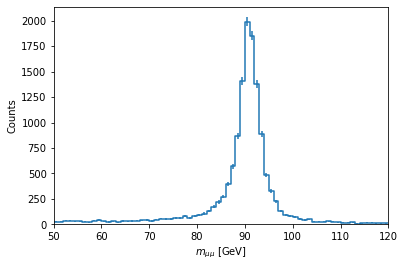

In [11]:
fig, ax, _ = plot.plot1d(masshist)

In [4]:
print("Events/s:", masshist.values()[()].sum()/elapsed)

Events/s: 22622.38840631572
